Compare no power control with UD-DPC in the noise-limited and interferencelimited scenarios. Set $P_{max}$ = 30 dBm, $P_{min}$ = 0 dBm and the discrete power control
update step as $\mu$ = 1 dBm. As for the target SINR required in UD-DPC, let us assume
the value corresponding to the QoS target of 100 Mbps at cell border under 100 MHz
which equates to 
$\gamma_t$ = 1. All other simulation parameters are kept in the same values
used in previous exercises. What are your observations? Did fixed-target SINR-based
power control (UD-DPC) help in any of the scenarios?


In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(12)

In [2]:
# Função que transforma Linear para dB
def lin2db(x):
    return 10 * np.log10(x)

# Função que transforma dB para Linear
def db2lin(x):
    return 10 ** (x / 10)

# Função que transforma Linear para dBm (watt)
def lin2dbm(x):
    return 10 * np.log10(x * 1000)

# Função que transforma dBm para Linear (watt)
def dbm2lin(x):
    return 10**(x / 10) / 1000

In [3]:
# Função que define os eixos x e y da CDF
def cdf(dados):
    '''Função que calcula a Cumulative Distribution Function (CDF) de um conjunto de dados.
    Parâmetros:
    dados: array. Conjunto de dados.
    Retorno:
    x: array. Dados ordenados.
    y: array. Probabilidade acumulada de cada dado.'''

    x = np.sort(dados)
    y = np.arange(1, len(x) + 1) / len(x)
    return x, y

In [4]:
# Função que gera as coordenadas dos APs
def distribuir_APs(num_aps, area):
    '''Distributes Access Points (APs) evenly within a square area.
    
    Parameters:
    num_aps (int): The number of APs to distribute. Must be a perfect square.
    area (int): The length of the side of the square area in which to distribute the APs.
    
    Returns:
    np.array: An array of coordinates for the APs, or None if num_aps is not a perfect square.'''
    
    if num_aps not in [1, 4, 9, 16, 25, 36, 49, 64, 100]:
        return None

    tamanho_quadrado = area
    lado_quadrado = int(np.sqrt(num_aps))

    tamanho_celula = tamanho_quadrado // lado_quadrado

    # Criar coordenadas usando meshgrid
    x, y = np.meshgrid(np.arange(0.5 * tamanho_celula, tamanho_quadrado, tamanho_celula),
                      np.arange(0.5 * tamanho_celula, tamanho_quadrado, tamanho_celula))

    coordenadas_APs = np.column_stack((x.ravel(), y.ravel()))

    return coordenadas_APs

In [5]:
# Função que gera a distância entre a UE e a AP
def dAPUE(x_coord, y_coord, ap_coord, d_reference=1):
  '''Calculate the Euclidean distance between a user equipment (UE) and an access point (AP).
    
    Parameters:
    ue_coords (tuple): A tuple (x_coord, y_coord) representing the coordinates of the UE.
    ap_coords (np.array): An array containing the coordinates of the APs.
    
    Returns:
    float: The Euclidean distance between the UE and the AP. If the euclidean distance is less than 1, return 1.
  '''
  dAPUE = np.linalg.norm(np.array([x_coord, y_coord]) - ap_coord)
  if dAPUE < d_reference:
    return d_reference
  else:
    return dAPUE

In [6]:
#Função que define o shadowing para cada usuário
def find_shadowing(standard_shadow, ues, aps):
    '''Generate a shadowing value for a user.

    Parameters:
    standard_shadow (float): The standard deviation of the shadowing values.
    ues (int): The number of user equipment (UE) in the simulation.
    aps (int): The number of access points (APs) in the

    Returns:
    np.array: A 2D array of shadowing values for each UE and AP.
    '''

    shadowing = np.random.lognormal(0, standard_shadow, (ues, aps))

    return shadowing 

In [7]:
def find_fastfading(standard_fading, ues, aps, channels):
    '''Função que calcula o fast fading para um dado usuário.
    
    Parâmetros:
    standard_fading (float): O desvio padrão da distribuição normal.
    ues (int): O número de usuários.
    aps (int): O número de pontos de acesso.
    channels (int): O número de canais.
    
    Retorna:
    np.array: Um array 3D com os valores de fast fading para cada usuário, ponto de acesso e canal.
    '''

    fast_fading = np.sqrt( (standard_fading * np.random.randn(ues, aps, channels))**2 + (standard_fading * np.random.randn(ues, aps, channels))**2 )

    return fast_fading

In [8]:
def find_pathgain(dist, shadowing, fastfading):
    ambiente_const = 1e-4
    pathloss_const = 4

    # Número de canais
    num_channels = fastfading.shape[2]

    # Expandindo o shadowing e o dist para ter a mesma forma que o fastfading
    shadowing_expanded = np.repeat(shadowing[:, :, np.newaxis], num_channels, axis=2)  # Agora tem forma (ues, aps, num_channels)
    dist_expanded = np.repeat((dist ** pathloss_const)[:, :, np.newaxis], num_channels, axis=2)  # Agora tem forma (ues, aps, num_channels)

    # Calculando o path gain
    path_gain_result = (shadowing_expanded * (ambiente_const / dist_expanded)) * (fastfading ** 2)

    return path_gain_result


In [9]:
def calculate_sinr(banda, K_0, aps, ues, channels, sigma_shadowing, sigma_fastfading, p_t, area, x_coord, y_coord):
    '''Função que calcula a SINR para múltiplos UEs e APs em diferentes canais.

    i-th UE, j-th AP, c-th channel
    
    Lembrando que [ue, aps, channels] é a dimensão da matriz path_gain. 

    Parâmetros:
    banda (float): Largura de banda total.
    K_0 (float): Constante de ruído.
    aps (int): Número de APs.
    ues (int): Número de UEs.
    channels (int): Número de canais.
    sigma_shadowing (float): Desvio padrão para o shadowing.
    sigma_fastfading (float): Desvio padrão para o fast fading.
    p_t (np.array): Potência de transmissão de cada UE.
    area (float): Área de distribuição dos APs.
    
    Retorna:
    np.array: O valor do SINR para cada UE.
    '''
    # Inicializações
    aps_position = distribuir_APs(aps, area)
    dist = np.zeros((ues, aps))

    # Shadowing já definido
    shadowing = np.array([[5.3434e-2, 2.8731e-1, 1.9691e-2, 7.3013e-1],
                          [3.2318, 1.5770, 2.6449e-1, 5.6379],
                          [6.1470e-3, 1.1424, 2.6826e-1, 4.5709],
                          [1.3485e-1, 4.6690e-1, 7.8250e-1, 1.6742]])
    
    # Fast fading definido no formato [ue, aps, channels]
    fastfading = np.array([[1.248699, 3.248041, 0.772754, 0.708962], 
                           [0.498887, 0.104890, 0.647280, 0.940906], 
                           [0.382966, 0.682700, 1.891256, 0.327100], 
                           [0.065737, 0.649500, 1.981107, 1.259538]]).reshape(ues, aps, channels)

    fastfading = np.sqrt(fastfading)
    
    power_trans = p_t
    power_noise = np.ones(ues) * (K_0 * banda / channels)

    # Cálculo da distância entre UEs e APs
    for ue_index in range(ues):
        for ap_index in range(aps):
            dist[ue_index, ap_index] = dAPUE(x_coord[ue_index], y_coord[ue_index], aps_position[ap_index])

    path_gain = find_pathgain(dist, shadowing, fastfading)

    # Seleção do AP com maior path gain para cada UE e zerando os outros
    for ue_index in range(ues):
        ap_max_index = np.argmax(path_gain[ue_index, :, :], axis=0)  # Seleciona o índice do AP com maior path gain
        for ap_index in range(aps):
            if ap_index != ap_max_index[0]:  # Mantém apenas o AP selecionado com path gain, zera os outros
                path_gain[ue_index, ap_index, :] = 0

    # Cálculo do SINR
    sinr_total = np.zeros(path_gain.shape)
    sinr_ue = np.zeros(path_gain.shape[0])

    for ue_index in range(path_gain.shape[0]):
        for ap_index in range(path_gain.shape[1]):
            for channel_index in range(path_gain.shape[2]):
                # Calculando a potência recebida para o canal atual
                power_received = np.abs(path_gain[ue_index, ap_index, channel_index]) * power_trans[ue_index]
    
                # Calculando a interferência no mesmo canal
                interference_sum = 0
                for other_ue_index in range(path_gain.shape[0]):
                    interference_sum += np.abs(path_gain[other_ue_index, ap_index, channel_index]) * power_trans[other_ue_index]

                # Cálculo da SINR para o canal, UE e AP atuais
                sinr_total[ue_index, ap_index, channel_index] = power_received / ((interference_sum - power_received) + power_noise[ue_index])

    # Selecionar o maior valor de SINR para cada UE
    for ue_index in range(sinr_total.shape[0]):
        sinr_ue[ue_index] = np.max(sinr_total[ue_index, :, :])

    return sinr_ue


In [10]:
def updown_dpc(aps, ues, channels, power_trans_max, power_trans_min, step, sinr_alvo, time, banda, K_0, area, sigma_shadowing, sigma_fastfading, x_coord, y_coord): 
    # Inicializa posições dos APs e distâncias
    aps_position = distribuir_APs(aps, area)
    dist = np.zeros((ues, aps))

    # Definindo o shadowing e o fast fading como matrizes fixas
    shadowing = np.array([[5.3434e-2, 2.8731e-1, 1.9691e-2, 7.3013e-1],
                          [3.2318, 1.5770, 2.6449e-1, 5.6379],
                          [6.1470e-3, 1.1424, 2.6826e-1, 4.5709],
                          [1.3485e-1, 4.6690e-1, 7.8250e-1, 1.6742]])
    fastfading = np.array([[1.248699, 3.248041, 0.772754, 0.708962], 
                           [0.498887, 0.104890, 0.647280, 0.940906], 
                           [0.382966, 0.682700, 1.891256, 0.327100], 
                           [0.065737, 0.649500, 1.981107, 1.259538]]).reshape(channels, ues, aps)

    fastfading = np.sqrt(fastfading)
    # Calculando a distância entre UEs e APs
    for ue_index in range(ues):
        for ap_index in range(aps):
            dist[ue_index][ap_index] = dAPUE(x_coord[ue_index], y_coord[ue_index], aps_position[ap_index])

    # Calculando o path gain
    path_gain = find_pathgain(dist, shadowing, fastfading)

    # Inicializa vetores de potência e alocação
    

    transmit_power = power_trans_max * np.ones((path_gain.shape[1], 1))
    power_sum = np.zeros(time)
    power_evolution = np.zeros((path_gain.shape[1], time))
    sinr_evolution = np.zeros((path_gain.shape[1], time))

    # Loop para cada instante de tempo
    for time_index in range(time):
        power_sum[time_index] = sum(transmit_power.flatten())

        # Salvar a evolução da potência para cada UE
        power_evolution[:, time_index] = transmit_power.flatten()

        # Calcula a SINR para cada usuário no tempo atual
        sinr_ue = calculate_sinr(banda, K_0, aps, ues, channels, sigma_shadowing, sigma_fastfading, dbm2lin(transmit_power), area, x_coord, y_coord)
        sinr_ue = lin2db(sinr_ue).reshape((ues, 1))

        # Salvar a evolução da SINR para cada UE
        sinr_evolution[:, time_index] = sinr_ue.flatten()

        # Atualiza a potência com base no erro entre a SINR alvo e a SINR atual
        transmit_power = transmit_power + step * np.sign(sinr_alvo - sinr_ue)

        # Aplica os limites de potência
        transmit_power = np.clip(transmit_power, power_trans_min, power_trans_max)

    return power_evolution, transmit_power, power_sum, sinr_evolution


In [11]:
def find_capacity(sinr, banda, channels):
    '''Função que calcula a capacidade de um dado canal.
    
    Parâmetros:
    sinr (array): A relação sinal ruído mais interferência.
    banda (int): A largura de banda do canal.    
    channels (int): O número de canais.
    Retorna:
    list: A capacidade do canal.'''

    capacity = banda * np.log2(1 + sinr)

    # Deixado no formato [channels, ues]
    capacity = capacity.reshape(channels, -1)

    return capacity

In [12]:
def noise_limited(aps, ues, channels, power_trans_max, power_trans_min, step, sinr_alvo, time, banda, K_0, area, sigma_shadowing, sigma_fastfading):
    
    x_coord = np.array([225.83, 566.79, 765.51, 265.95])
    y_coord = np.array([203.33, 321.88, 146.88, 702.39])

    # Deixando a SINR no formato [ues, time] e a capacidade no formato [ues, time]
    sinr_max_vector = np.zeros((ues, time))
    sinr_dpc_vector = np.zeros((ues, time))
    capacity_max_vector = np.zeros((ues, time))
    capacity_dpc_vector = np.zeros((ues, time))

    # Definindo os dois tipos de controle de potência a ser utilizado:
    # 1. UpDownDPC
    transmit_power_dpc = updown_dpc(aps, ues, channels, power_trans_max, power_trans_min, step, sinr_alvo, time, banda, K_0, area, sigma_shadowing, sigma_fastfading, x_coord, y_coord)
    # Deixando a potência no formato [ues, time]
    transmit_power_dpc = transmit_power_dpc[0].reshape(ues, time) # Esse formato foi escolhido para facilitar a visualização dos dados e achado de maneira impirica

    # 2. Power Max
    transmit_power_max = power_trans_max*np.ones((ues, time))



    for time_index in range (time):

        # Calculando a SINR para cada usuário utilizando o Power Max
        trans_power_max_lin = dbm2lin(transmit_power_max[:, time_index])

        sinr_max = calculate_sinr(banda, K_0, aps, ues, channels, sigma_shadowing, sigma_fastfading, trans_power_max_lin, area, x_coord, y_coord)

        # Calculando a capacidade para cada usuário utilizando o Power Max
        capacity_max = find_capacity(sinr_max, banda, channels)

        trans_power_dpc_lin = dbm2lin(transmit_power_dpc[:,time_index])

        # Calculando a SINR para cada usuário utilizando o UpDownDPC
        sinr_dpc = calculate_sinr(banda, K_0, aps, ues, channels, sigma_shadowing, sigma_fastfading, trans_power_dpc_lin, area, x_coord, y_coord)

        # Calculando a capacidade para cada usuário utilizando o UpDownDPC
        capacity_dpc = find_capacity(sinr_dpc, banda, channels)

        # Alocando os valores de SINR e capacidade para cada usuário para cada momento
        sinr_max_vector[:, time_index] = sinr_max
        sinr_dpc_vector[:, time_index] = sinr_dpc
        capacity_max_vector[:, time_index] = capacity_max
        capacity_dpc_vector[:, time_index] = capacity_dpc

    return sinr_max_vector, sinr_dpc_vector, capacity_max_vector, capacity_dpc_vector        

In [13]:
bandwidth , transmit_power, d_min, K_0 = 100e6, 1, 1, 1e-20 # Em MHz, mW, metros, mW/Hz respectivamente
aps, ues, channels = 4, 4, 1
area_noiselimited = 1000
area_interferencelimited = 100
sigma_shadowing = 2
sigma_fastfading = 1/np.sqrt(2)


In [14]:
power_trans_max = 30 # Em dBm
power_trans_min = 0 # Em dBm
step = 1 # Em dBm

In [15]:
# Definindo o SINR alvo
sinr_alvo = 1

# Definindo o tempo de simulação
time = 100

# Fazendo a simulação
sinr_max_vector, sinr_dpc_vector, capacity_max_vector, capacity_dpc_vector = noise_limited(aps, ues, channels, power_trans_max, power_trans_min, step, sinr_alvo, time, bandwidth, K_0, area_noiselimited, sigma_shadowing, sigma_fastfading)

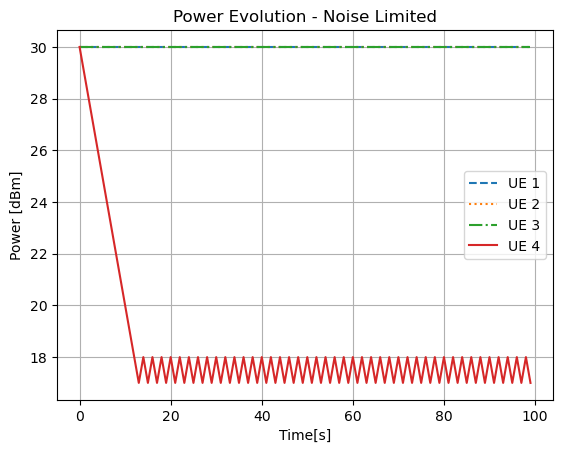

[[30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30.
  30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30.
  30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30.
  30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30.
  30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30.
  30. 30. 30. 30. 30. 30. 30. 30. 30. 30.]
 [30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30.
  30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30.
  30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30.
  30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30.
  30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30.
  30. 30. 30. 30. 30. 30. 30. 30. 30. 30.]
 [30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30.
  30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30.
  30. 30. 30. 30. 30. 30. 

In [16]:
# Plotando a evolução da potência de transmissão

x_coord = [225.83, 566.79, 765.51, 265.95]
y_coord = [203.33, 321.88, 146.88, 702.39]

a = updown_dpc(aps, ues, channels, power_trans_max, power_trans_min, step, sinr_alvo, time, bandwidth, K_0, area_noiselimited, sigma_shadowing, sigma_fastfading, x_coord, y_coord)
# Descobrindo qual as dimensões de a

a = a[0]



plt.figure()
plt.plot(a[0], label='UE 1', linestyle='--')
plt.plot(a[1], label='UE 2', linestyle=':')
plt.plot(a[2], label='UE 3', linestyle='-.')
plt.plot(a[3], label='UE 4')
plt.grid()
plt.legend()
plt.xlabel('Time[s]')
plt.ylabel('Power [dBm]')
plt.title('Power Evolution - Noise Limited')
plt.savefig('Q7_power_evolution_noiselimited.pdf')
plt.show()

print(a)


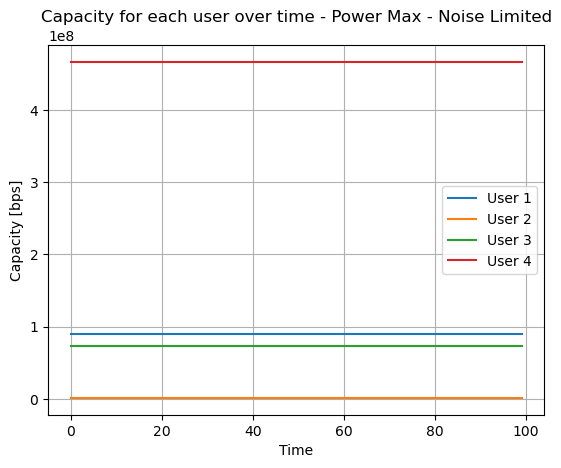

In [17]:
# Plotando a capacidade para cada usuário para cada momento utilizando o Power Max
plt.figure()
plt.plot(capacity_max_vector[0, :], label='User 1')
plt.plot(capacity_max_vector[1, :], label='User 2')
plt.plot(capacity_max_vector[2, :], label='User 3')
plt.plot(capacity_max_vector[3, :], label='User 4')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Capacity [bps]')
plt.title('Capacity for each user over time - Power Max - Noise Limited')
plt.grid()
plt.savefig('Q7_capacity_noiselimited_powermax.pdf')
plt.show()

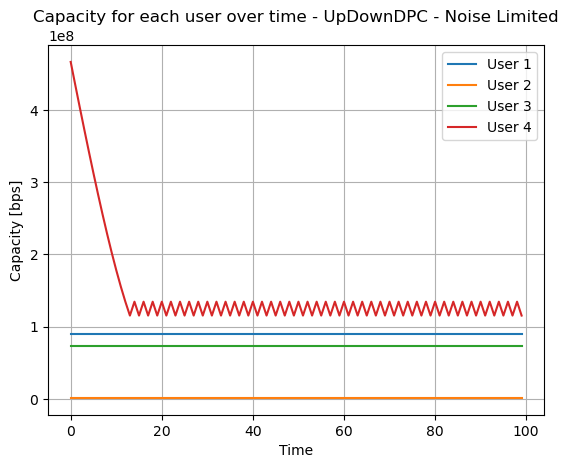

In [18]:
# Plotando a capacidade para cada usuário para cada momento utilizando o UpDownDPC

plt.figure()
plt.plot(capacity_dpc_vector[0, :], label='User 1')
plt.plot(capacity_dpc_vector[1, :], label='User 2')
plt.plot(capacity_dpc_vector[2, :], label='User 3')
plt.plot(capacity_dpc_vector[3, :], label='User 4')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Capacity [bps]')
plt.title('Capacity for each user over time - UpDownDPC - Noise Limited')
plt.grid()
plt.savefig('Q7_capacity_noiselimited_updowndpc.pdf')
plt.show()


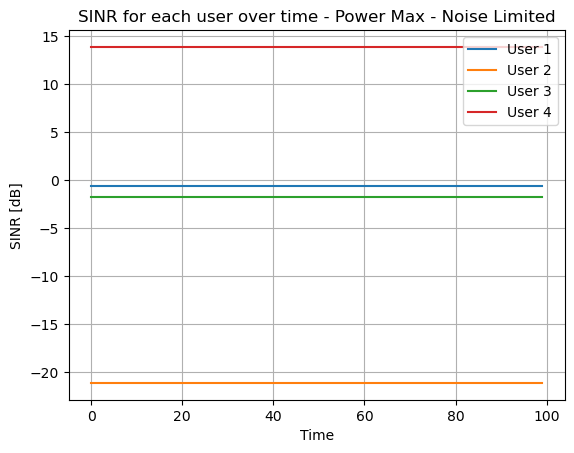

In [19]:
# Plotando a SINR para cada usuário para cada momento utilizando o Power Max
plt.figure()
plt.plot(lin2db(sinr_max_vector[0, :]), label='User 1')
plt.plot(lin2db(sinr_max_vector[1, :]), label='User 2')
plt.plot(lin2db(sinr_max_vector[2, :]), label='User 3')
plt.plot(lin2db(sinr_max_vector[3, :]), label='User 4')
plt.legend()
plt.xlabel('Time')
plt.ylabel('SINR [dB]')
plt.title('SINR for each user over time - Power Max - Noise Limited')
plt.grid()
plt.savefig('Q7_sinr_noiselimited_powermax.pdf')
plt.show()

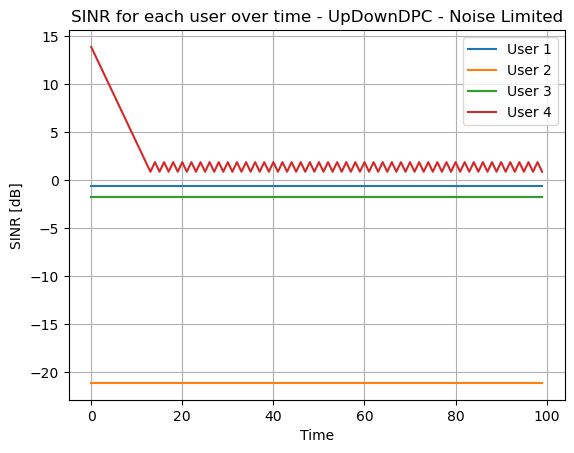

[13.87207104 12.87207104 11.87207104 10.87207104  9.87207104  8.87207104
  7.87207104  6.87207104  5.87207104  4.87207104  3.87207104  2.87207104
  1.87207104  0.87207104  1.87207104  0.87207104  1.87207104  0.87207104
  1.87207104  0.87207104  1.87207104  0.87207104  1.87207104  0.87207104
  1.87207104  0.87207104  1.87207104  0.87207104  1.87207104  0.87207104
  1.87207104  0.87207104  1.87207104  0.87207104  1.87207104  0.87207104
  1.87207104  0.87207104  1.87207104  0.87207104  1.87207104  0.87207104
  1.87207104  0.87207104  1.87207104  0.87207104  1.87207104  0.87207104
  1.87207104  0.87207104  1.87207104  0.87207104  1.87207104  0.87207104
  1.87207104  0.87207104  1.87207104  0.87207104  1.87207104  0.87207104
  1.87207104  0.87207104  1.87207104  0.87207104  1.87207104  0.87207104
  1.87207104  0.87207104  1.87207104  0.87207104  1.87207104  0.87207104
  1.87207104  0.87207104  1.87207104  0.87207104  1.87207104  0.87207104
  1.87207104  0.87207104  1.87207104  0.87207104  1

In [20]:
# Plotando a SINR para cada usuário para cada momento utilizando o UpDownDPC
plt.figure()
plt.plot(lin2db(sinr_dpc_vector[0, :]), label='User 1')
plt.plot(lin2db(sinr_dpc_vector[1, :]), label='User 2')
plt.plot(lin2db(sinr_dpc_vector[2, :]), label='User 3')
plt.plot(lin2db(sinr_dpc_vector[3, :]), label='User 4')
plt.legend()
plt.xlabel('Time')
plt.ylabel('SINR [dB]')
plt.title('SINR for each user over time - UpDownDPC - Noise Limited')
plt.grid()
plt.savefig('Q7_sinr_noiselimited_updowndpc.pdf')
plt.show()
print(lin2db(sinr_dpc_vector[3, :]))

In [21]:
def interference_limited(aps, ues, channels, power_trans_max, power_trans_min, step, sinr_alvo, time, banda, K_0, area, sigma_shadowing, sigma_fastfading):
    
    x_coord = np.array([22.583, 56.679, 76.551, 26.595])
    y_coord = np.array([20.333, 32.188, 14.688, 70.239])

    # Deixando a SINR no formato [ues, time] e a capacidade no formato [ues, time]
    sinr_max_vector = np.zeros((ues, time))
    sinr_dpc_vector = np.zeros((ues, time))
    capacity_max_vector = np.zeros((ues, time))
    capacity_dpc_vector = np.zeros((ues, time))

    # Definindo os dois tipos de controle de potência a ser utilizado:
    # 1. UpDownDPC
    transmit_power_dpc = updown_dpc(aps, ues, channels, power_trans_max, power_trans_min, step, sinr_alvo, time, banda, K_0, area, sigma_shadowing, sigma_fastfading, x_coord, y_coord)
    # Deixando a potência no formato [ues, time]
    transmit_power_dpc = transmit_power_dpc[0].reshape(ues, time) # Esse formato foi escolhido para facilitar a visualização dos dados e achado de maneira impirica

    # 2. Power Max
    transmit_power_max = power_trans_max*np.ones((ues, time))



    for time_index in range (time):

        # Calculando a SINR para cada usuário utilizando o Power Max
        trans_power_max_lin = dbm2lin(transmit_power_max[:, time_index])

        sinr_max = calculate_sinr(banda, K_0, aps, ues, channels, sigma_shadowing, sigma_fastfading, trans_power_max_lin, area, x_coord, y_coord)

        # Calculando a capacidade para cada usuário utilizando o Power Max
        capacity_max = find_capacity(sinr_max, banda, channels)

        trans_power_dpc_lin = dbm2lin(transmit_power_dpc[:,time_index])

        # Calculando a SINR para cada usuário utilizando o UpDownDPC
        sinr_dpc = calculate_sinr(banda, K_0, aps, ues, channels, sigma_shadowing, sigma_fastfading, trans_power_dpc_lin, area, x_coord, y_coord)

        # Calculando a capacidade para cada usuário utilizando o UpDownDPC
        capacity_dpc = find_capacity(sinr_dpc, banda, channels)

        # Alocando os valores de SINR e capacidade para cada usuário para cada momento
        sinr_max_vector[:, time_index] = sinr_max
        sinr_dpc_vector[:, time_index] = sinr_dpc
        capacity_max_vector[:, time_index] = capacity_max
        capacity_dpc_vector[:, time_index] = capacity_dpc

    return sinr_max_vector, sinr_dpc_vector, capacity_max_vector, capacity_dpc_vector
        

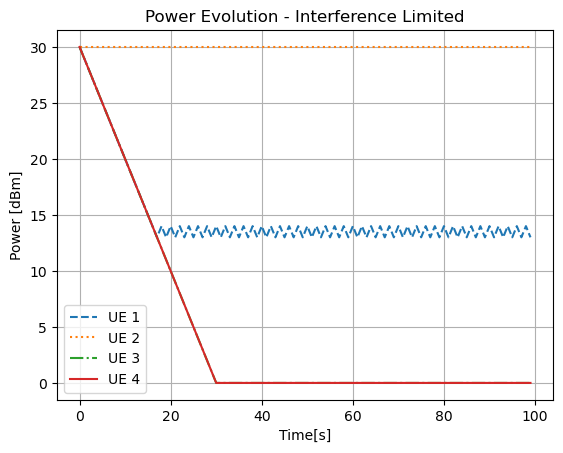

In [22]:
# Plotando a evolução da potência de transmissão

x_coord = [22.583, 56.679, 76.551, 26.595]
y_coord = [20.333, 32.188, 14.688, 70.239]

a_interference = updown_dpc(aps, ues, channels, power_trans_max, power_trans_min, step, sinr_alvo, time, bandwidth, K_0, area_interferencelimited, sigma_shadowing, sigma_fastfading, x_coord, y_coord)

a_interference = a_interference[0]

plt.figure()
plt.plot(a_interference[0], label='UE 1', linestyle='--')
plt.plot(a_interference[1], label='UE 2', linestyle=':')
plt.plot(a_interference[2], label='UE 3', linestyle='-.')
plt.plot(a_interference[3], label='UE 4')
plt.grid()
plt.legend()
plt.xlabel('Time[s]')
plt.ylabel('Power [dBm]')
plt.title('Power Evolution - Interference Limited')
plt.savefig('Q7_power_evolution_interferencelimited.pdf')
plt.show()


In [23]:
sinr_max_vector, sinr_dpc_vector, capacity_max_vector, capacity_dpc_vector = interference_limited(aps, ues, channels, power_trans_max, power_trans_min, step, sinr_alvo, time, bandwidth, K_0, area_interferencelimited, sigma_shadowing, sigma_fastfading)


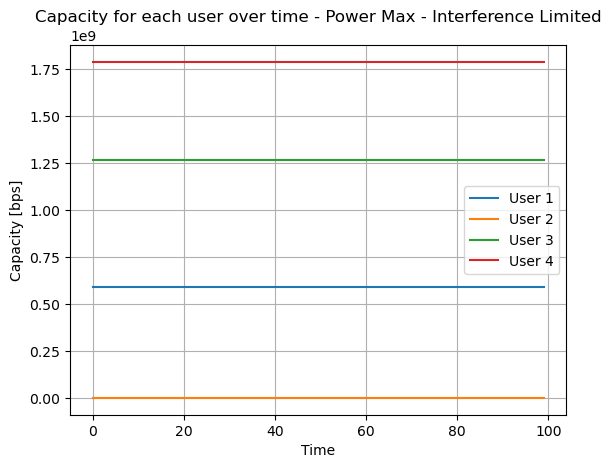

In [24]:
# Plotando a capacidade para cada usuário para cada momento utilizando o Power Max
plt.figure()
plt.plot(capacity_max_vector[0, :], label='User 1')
plt.plot(capacity_max_vector[1, :], label='User 2')
plt.plot(capacity_max_vector[2, :], label='User 3')
plt.plot(capacity_max_vector[3, :], label='User 4')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Capacity [bps]')
plt.title('Capacity for each user over time - Power Max - Interference Limited')
plt.grid()
plt.savefig('Q7_capacity_interferencelimited_powermax.pdf')
plt.show()


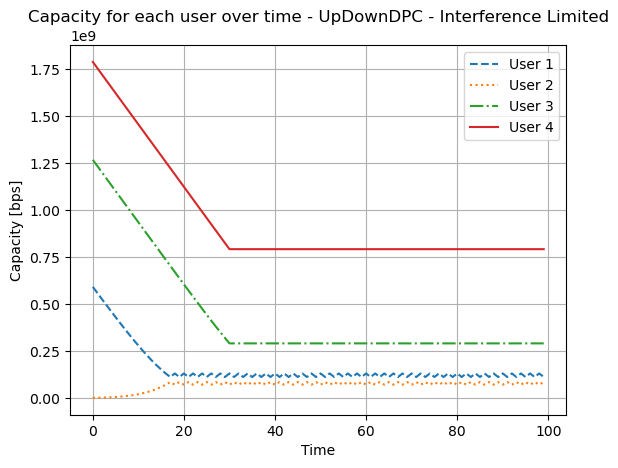

In [25]:
# Plotando a capacidade para cada usuário para cada momento utilizando o UpDownDPC
plt.figure()
plt.plot(capacity_dpc_vector[0, :], label='User 1', linestyle='--')
plt.plot(capacity_dpc_vector[1, :], label='User 2', linestyle=':')
plt.plot(capacity_dpc_vector[2, :], label='User 3', linestyle='-.')
plt.plot(capacity_dpc_vector[3, :], label='User 4', linestyle='-')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Capacity [bps]')
plt.title('Capacity for each user over time - UpDownDPC - Interference Limited')
plt.grid()
plt.savefig('Q7_capacity_interferencelimited_updowndpc.pdf')
plt.show()


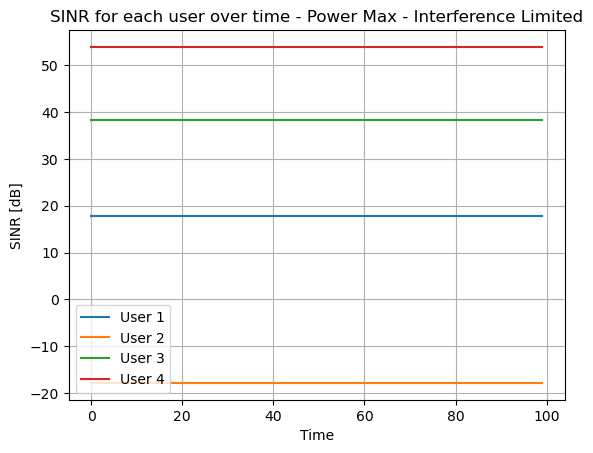

In [26]:
# Plotando a SINR para cada usuário para cada momento utilizando o Power Max
plt.figure()
plt.plot(lin2db(sinr_max_vector[0, :]), label='User 1')
plt.plot(lin2db(sinr_max_vector[1, :]), label='User 2')
plt.plot(lin2db(sinr_max_vector[2, :]), label='User 3')
plt.plot(lin2db(sinr_max_vector[3, :]), label='User 4')
plt.legend()
plt.xlabel('Time')
plt.ylabel('SINR [dB]')
plt.title('SINR for each user over time - Power Max - Interference Limited')
plt.grid()
plt.savefig('Q7_sinr_interferencelimited_powermax.pdf')
plt.show()


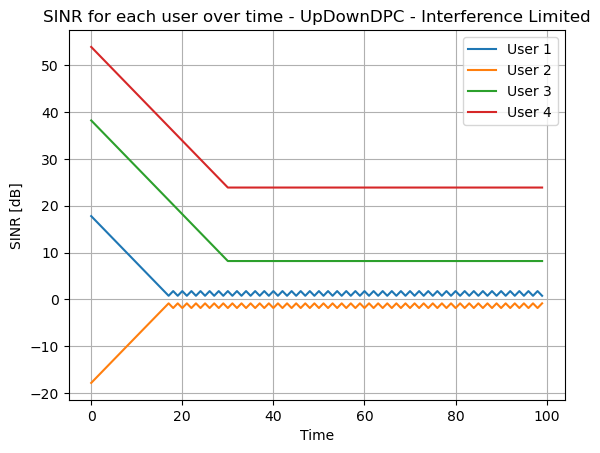

In [27]:
# Plotando a SINR para cada usuário para cada momento utilizando o UpDownDPC
plt.figure()
plt.plot(lin2db(sinr_dpc_vector[0, :]), label='User 1')
plt.plot(lin2db(sinr_dpc_vector[1, :]), label='User 2')
plt.plot(lin2db(sinr_dpc_vector[2, :]), label='User 3')
plt.plot(lin2db(sinr_dpc_vector[3, :]), label='User 4')
plt.legend()
plt.xlabel('Time')
plt.ylabel('SINR [dB]')
plt.title('SINR for each user over time - UpDownDPC - Interference Limited')
plt.grid()
plt.savefig('Q7_sinr_interferencelimited_updowndpc.pdf')
plt.show()


You are now in condition to test the two objective functions $F_1$ and $F_2$
defined above that represent two diferent views for power control in data-centric wireless
systems. Apply the ESNP algorithm above for each objective function $F_1$ and $F_2$. Adopt
$\epsilon = 0.5$ and $\delta = 10$ dBm: The number of iterations can be large for convergence. As a
suggestion, monitor the evolution of the changes in $F^*$ and $\textbf{\underline{P}}^*$
in step 12 of the ESNP
algorithm so as to identify stabilization of the convergence process. Obtain the KPIs and
organize results in graphics and tables. Compare with results from no power control and
UD-DPC of the previous exercise in both noise-limited and interference-limited scenarios
deÖned in Appendix A. Discuss with your advisor if the results make sense in light of
the two objective functions.


In [28]:
neighb_factor = 10 # Em dBm | delta
prob_param = 0.5 # epsilon

In [29]:
x_coord_noise = np.array([225.83, 566.79, 765.51, 265.95])
y_coord_noise = np.array([203.33, 321.88, 146.88, 702.39])
x_coord_interference = np.array([22.583, 56.679, 76.551, 26.595])
y_coord_interference = np.array([20.333, 32.188, 14.688, 70.239])

In [30]:
def esnp_maxmin(aps, ues, channels, power_trans_max, power_trans_min, step, time, banda, K_0, area, x_coord, y_coord, neighb_factor, prob_param, sigma_fastfading, sigma_shadowing):
    # Inicializa posições dos APs e distâncias
    aps_position = distribuir_APs(aps, area)
    dist = np.zeros((ues, aps))

    # Definindo o shadowing e o fast fading como matrizes fixas
    shadowing = np.array([[5.3434e-2, 2.8731e-1, 1.9691e-2, 7.3013e-1],
                          [3.2318, 1.5770, 2.6449e-1, 5.6379],
                          [6.1470e-3, 1.1424, 2.6826e-1, 4.5709],
                          [1.3485e-1, 4.6690e-1, 7.8250e-1, 1.6742]])
    fastfading = np.array([[1.248699, 3.248041, 0.772754, 0.708962], 
                           [0.498887, 0.104890, 0.647280, 0.940906], 
                           [0.382966, 0.682700, 1.891256, 0.327100], 
                           [0.065737, 0.649500, 1.981107, 1.259538]]).reshape(channels, ues, aps)
    
    fastfading = np.sqrt(fastfading)

    # Salvar a evolução da potência, SINR, capacidade e valor da menor SINR
    power_evolution = np.zeros((ues, time))
    sinr_evolution = np.zeros((ues, time))
    capacity_evolution = np.zeros((ues, time))
    min_sinr_evolution = np.zeros(time)

    # Calculando a distância entre UEs e APs
    for ue_index in range(ues):
        for ap_index in range(aps):
            dist[ue_index][ap_index] = dAPUE(x_coord[ue_index], y_coord[ue_index], aps_position[ap_index])

    # Calculando o path gain
    path_gain = find_pathgain(dist, shadowing, fastfading)

    # Setando os valores possíveis de potência de transmissão
    available_power = np.arange(power_trans_min, power_trans_max + step, step)  # em dBm

    # Inicializa vetores de potência e alocação
    transmit_power = power_trans_max * np.ones((path_gain.shape[1], 1))

    # Valor inicial de maxmin
    f_maxmin = -np.inf

    for time_index in range(time):
        # Calcula a SINR para cada usuário no tempo atual
        sinr_ue = calculate_sinr(banda, K_0, aps, ues, channels, sigma_shadowing, sigma_fastfading, dbm2lin(transmit_power), area, x_coord, y_coord)
        sinr_ue = sinr_ue.reshape((ues, 1))  # Em Linear

        # Converte para dB para a evolução do SINR
        sinr_ue_db = lin2db(sinr_ue)

        # Calcula a capacidade para cada UE em bps usando a largura de banda
        capacity_ue = banda * np.log2(1 + sinr_ue)  # Em bps

        # Salva a evolução da potência, SINR e capacidade para cada UE
        power_evolution[:, time_index] = transmit_power.flatten()
        sinr_evolution[:, time_index] = sinr_ue_db.flatten()
        capacity_evolution[:, time_index] = capacity_ue.flatten()

        # Calcula a menor SINR e atualiza a função objetivo se necessário
        min_sinr = np.min(sinr_ue_db)

        if min_sinr > f_maxmin:
            f_maxmin = min_sinr
            best_power = transmit_power.copy()  # Guarda a melhor configuração de potência

        # Armazena o valor de maxmin SINR para análise
        min_sinr_evolution[time_index] = f_maxmin

        # Probabilidade de escolher um valor de potência aleatório ou ajustar com perturbação
        random = np.random.rand()
        if random < 0:  # prob_param é equivalente ao epsilon
            # Escolha aleatória de transmit_power no conjunto de valores possíveis
            for ue_index in range(ues):
                transmit_power[ue_index] = np.random.choice(available_power)
        else:
            # Perturbação controlada pela vizinhança para explorar o espaço de soluções
            delta = neighb_factor
            perturbation = delta * (np.random.rand(ues, 1) - 0.5)
            transmit_power = best_power + perturbation

        # Aplica restrições de limite de potência
        transmit_power = np.clip(transmit_power, power_trans_min, power_trans_max)

    return best_power, power_evolution, sinr_evolution, min_sinr_evolution, capacity_evolution


In [31]:
time = 100

# Noise Limited - ESNP Max Min
best_power_maxmin_noise, power_evolution_maxmin_noise, sinr_evolution_maxmin_noise, min_sinr_evolution_maxmin_noise, capacity_esnp_maxmin_noise = esnp_maxmin(aps, ues, channels, power_trans_max, power_trans_min, step, time, bandwidth, K_0, area_noiselimited, x_coord_noise, y_coord_noise, neighb_factor, prob_param, sigma_fastfading, sigma_shadowing)

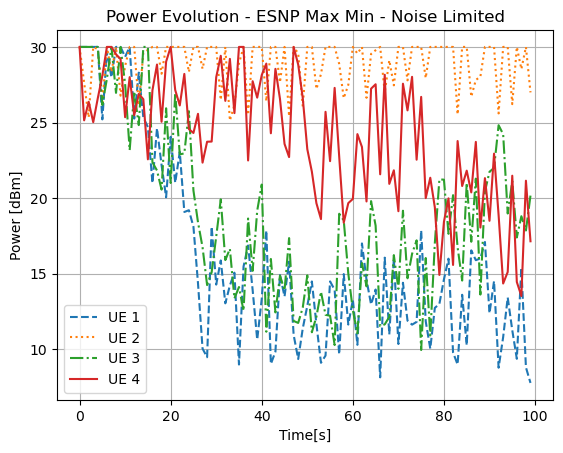

In [32]:
# Plotando a evolução da potência de transmissão MaxMin
plt.figure()
plt.plot(power_evolution_maxmin_noise[0, :], label='UE 1', linestyle='--')
plt.plot(power_evolution_maxmin_noise[1, :], label='UE 2', linestyle=':')
plt.plot(power_evolution_maxmin_noise[2, :], label='UE 3', linestyle='-.')
plt.plot(power_evolution_maxmin_noise[3, :], label='UE 4')
plt.grid()
plt.legend()
plt.xlabel('Time[s]')
plt.ylabel('Power [dBm]')
plt.title('Power Evolution - ESNP Max Min - Noise Limited')
plt.savefig('Q8_power_evolution_noiselimited_espnmaxmin.pdf')
plt.show()

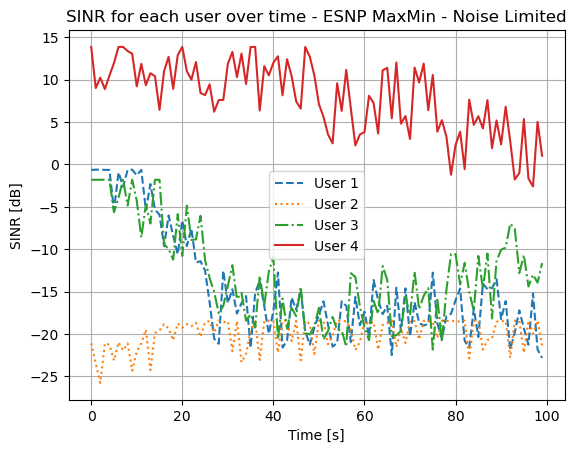

In [33]:
# Plotando a SINR para cada usuário para cada momento utilizando o MaxMin
plt.figure()
plt.plot(sinr_evolution_maxmin_noise[0, :], label='User 1', linestyle='--')
plt.plot(sinr_evolution_maxmin_noise[1, :], label='User 2', linestyle=':')
plt.plot(sinr_evolution_maxmin_noise[2, :], label='User 3', linestyle='-.')
plt.plot(sinr_evolution_maxmin_noise[3, :], label='User 4')
plt.legend()
plt.xlabel('Time [s]')
plt.ylabel('SINR [dB]')
plt.title('SINR for each user over time - ESNP MaxMin - Noise Limited')
plt.grid()
plt.savefig('Q8_sinr_noiselimited_espnmaxmin.pdf')
plt.show()

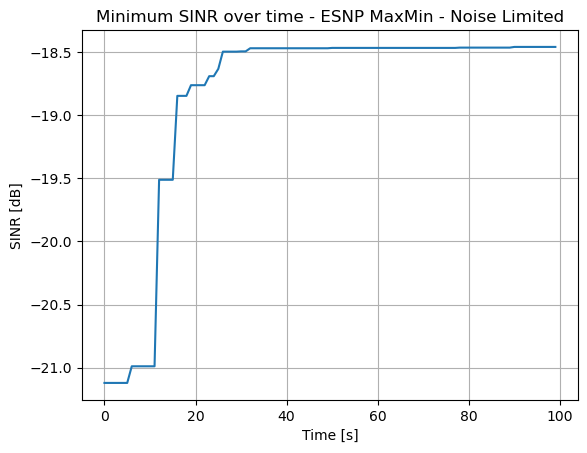

In [34]:
# Plotando a evolução da SINR minima para cada instante de tempo utilizando o MaxMin
plt.figure()
plt.plot(min_sinr_evolution_maxmin_noise)
plt.grid()
plt.xlabel('Time [s]')
plt.ylabel('SINR [dB]')
plt.title('Minimum SINR over time - ESNP MaxMin - Noise Limited')
plt.savefig('Q8_min_sinr_noiselimited_espnmaxmin.pdf')
plt.show()

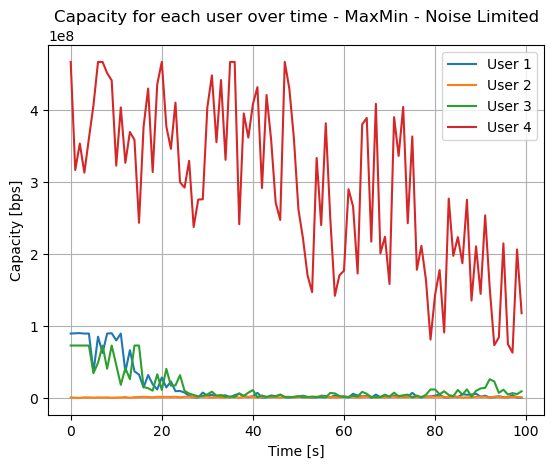

In [35]:
# Plotando a capacidade para cada usuário para cada momento utilizando o MaxMin
plt.figure()
plt.plot(capacity_esnp_maxmin_noise[0, :], label='User 1')
plt.plot(capacity_esnp_maxmin_noise[1, :], label='User 2')
plt.plot(capacity_esnp_maxmin_noise[2, :], label='User 3')
plt.plot(capacity_esnp_maxmin_noise[3, :], label='User 4')
plt.legend()
plt.xlabel('Time [s]')
plt.ylabel('Capacity [bps]')
plt.title('Capacity for each user over time - MaxMin - Noise Limited')
plt.grid()
plt.savefig('Q8_capacity_noiselimited_espnmaxmin.pdf')
plt.show()


In [36]:
# Interference Limited - ESNP Max Min
best_power_maxmin_interference, power_evolution_maxmin_interference, sinr_evolution_maxmin_interference, min_sinr_evolution_maxmin_interference, capacity_esnp_maxmin_interference = esnp_maxmin(aps, ues, channels, power_trans_max, power_trans_min, step, time, bandwidth, K_0, area_interferencelimited, x_coord_interference, y_coord_interference, neighb_factor, prob_param, sigma_fastfading, sigma_shadowing)


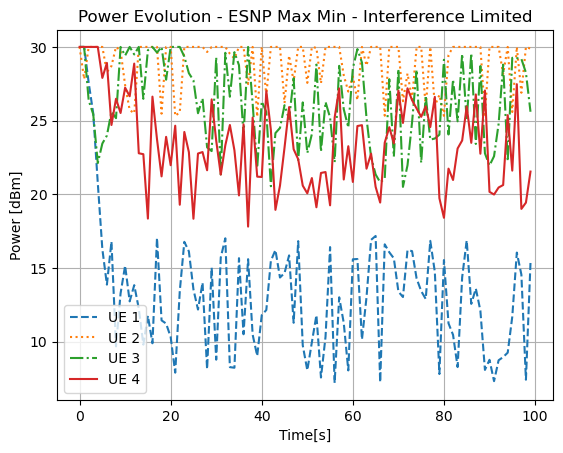

In [37]:
# Plotando a evolução da potência de transmissão MaxMin - Interference Limited 

plt.figure()
plt.plot(power_evolution_maxmin_interference[0, :], label='UE 1', linestyle='--')
plt.plot(power_evolution_maxmin_interference[1, :], label='UE 2', linestyle=':')
plt.plot(power_evolution_maxmin_interference[2, :], label='UE 3', linestyle='-.')
plt.plot(power_evolution_maxmin_interference[3, :], label='UE 4')
plt.grid()
plt.legend()
plt.xlabel('Time[s]')
plt.ylabel('Power [dBm]')
plt.title('Power Evolution - ESNP Max Min - Interference Limited')
plt.savefig('Q8_power_evolution_interferencelimited_espnmaxmin.pdf')
plt.show()

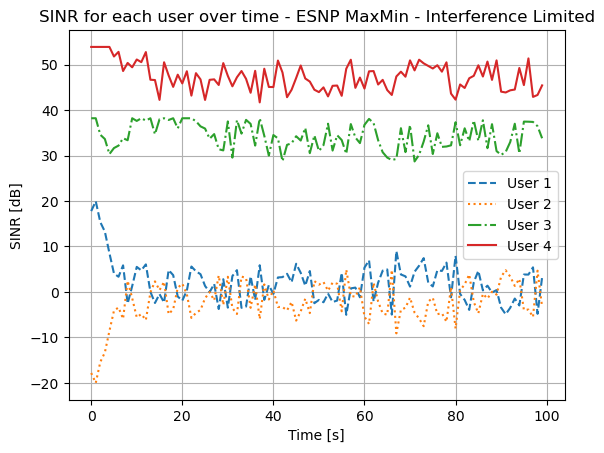

In [38]:
# Plotando a SINR para cada usuário para cada momento utilizando o MaxMin - Interference Limited

plt.figure()
plt.plot(sinr_evolution_maxmin_interference[0, :], label='User 1', linestyle='--')
plt.plot(sinr_evolution_maxmin_interference[1, :], label='User 2', linestyle=':')
plt.plot(sinr_evolution_maxmin_interference[2, :], label='User 3', linestyle='-.')
plt.plot(sinr_evolution_maxmin_interference[3, :], label='User 4')
plt.legend()
plt.xlabel('Time [s]')
plt.ylabel('SINR [dB]')
plt.title('SINR for each user over time - ESNP MaxMin - Interference Limited')
plt.grid()
plt.savefig('Q8_sinr_interferencelimited_espnmaxmin.pdf')
plt.show()

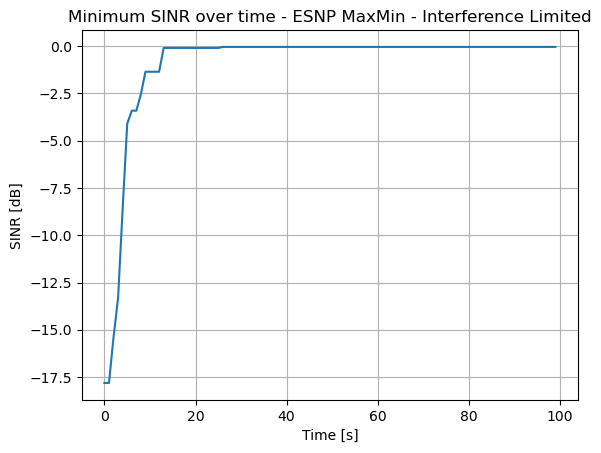

In [39]:
# Plotando a evolução da SINR minima para cada instante de tempo utilizando o MaxMin - Interference Limited

plt.figure()
plt.plot(min_sinr_evolution_maxmin_interference)
plt.grid()
plt.xlabel('Time [s]')
plt.ylabel('SINR [dB]')
plt.title('Minimum SINR over time - ESNP MaxMin - Interference Limited')
plt.savefig('Q8_min_sinr_interferencelimited_espnmaxmin.pdf')
plt.show()

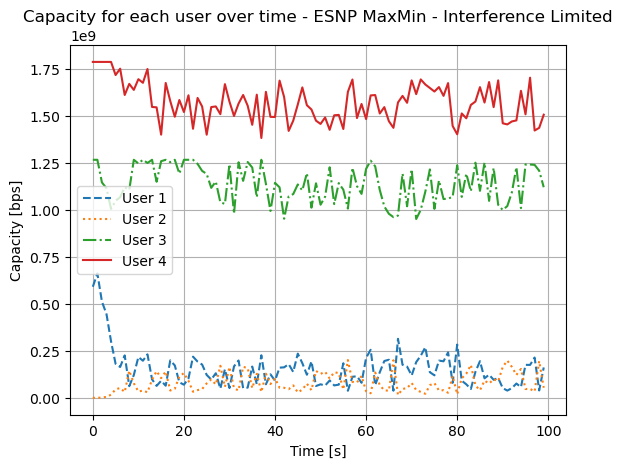

In [40]:
# Plotando a capacidade para cada usuário para cada momento utilizando o MaxMin - Interference Limited

plt.figure()
plt.plot(capacity_esnp_maxmin_interference[0, :], label='User 1', linestyle='--')
plt.plot(capacity_esnp_maxmin_interference[1, :], label='User 2', linestyle=':')
plt.plot(capacity_esnp_maxmin_interference[2, :], label='User 3', linestyle='-.')
plt.plot(capacity_esnp_maxmin_interference[3, :], label='User 4')
plt.legend()
plt.xlabel('Time [s]')
plt.ylabel('Capacity [bps]')
plt.title('Capacity for each user over time - ESNP MaxMin - Interference Limited')
plt.grid()
plt.savefig('Q8_capacity_interferencelimited_espnmaxmin.pdf')
plt.show()


In [143]:
def esnp_maxsum(aps, ues, channels, power_trans_max, power_trans_min, step, time, banda, K_0, area, x_coord, y_coord, neighb_factor, epsilon, sigma_fastfading, sigma_shadowing):
    # Inicializa posições dos APs e distâncias
    aps_position = distribuir_APs(aps, area)
    dist = np.zeros((ues, aps))

    # Definindo o shadowing e o fast fading como matrizes fixas
    shadowing = np.array([[5.3434e-2, 2.8731e-1, 1.9691e-2, 7.3013e-1],
                          [3.2318, 1.5770, 2.6449e-1, 5.6379],
                          [6.1470e-3, 1.1424, 2.6826e-1, 4.5709],
                          [1.3485e-1, 4.6690e-1, 7.8250e-1, 1.6742]])
    fastfading = np.array([[1.248699, 3.248041, 0.772754, 0.708962], 
                           [0.498887, 0.104890, 0.647280, 0.940906], 
                           [0.382966, 0.682700, 1.891256, 0.327100], 
                           [0.065737, 0.649500, 1.981107, 1.259538]]).reshape(channels, ues, aps)
    
    fastfading = np.sqrt(fastfading)

    # Salvar a evolução da potência, SINR, capacidade e soma das SINRs
    power_evolution = np.zeros((ues, time))
    sinr_evolution = np.zeros((ues, time))
    capacity_evolution = np.zeros((ues, time))
    sum_sinr_evolution = np.zeros(time)

    # Calculando a distância entre UEs e APs
    for ue_index in range(ues):
        for ap_index in range(aps):
            dist[ue_index][ap_index] = dAPUE(x_coord[ue_index], y_coord[ue_index], aps_position[ap_index])

    # Calculando o path gain
    path_gain = find_pathgain(dist, shadowing, fastfading)
    
    # Setando os valores possíveis de potência de transmissão
    available_power = np.arange(power_trans_min, power_trans_max + step, step)  # em dBm

    # Inicializa vetores de potência e alocação
    transmit_power = power_trans_max * np.ones((ues, 1))  # Potência inicial máxima
    best_power = transmit_power.copy()  # Guarda a melhor configuração de potência
    
    # Valor inicial de função objetivo (soma de SINRs)
    f_sumax = 0

    for time_index in range(time):
        # Calcula a SINR para cada usuário no tempo atual
        sinr_ue = calculate_sinr(banda, K_0, aps, ues, channels, sigma_shadowing, sigma_fastfading, dbm2lin(transmit_power), area, x_coord, y_coord)
        sinr_ue = sinr_ue.reshape((ues, 1))  # Em Linear

        # Salva a evolução de potência e SINR para cada UE
        power_evolution[:, time_index] = transmit_power.flatten()
        sinr_evolution[:, time_index] = lin2db(sinr_ue).flatten()

        # Calcula a capacidade para cada UE em bps usando a largura de banda
        capacity_ue = banda * np.log2(1 + sinr_ue)  # Em bps
        capacity_evolution[:, time_index] = capacity_ue.flatten()

        # Calcula a soma das SINRs em linear
        sum_sinr = np.sum(sinr_ue)

        # Atualiza o valor de melhor função objetivo e potência se o novo valor for melhor
        if sum_sinr > f_sumax:
            f_sumax = sum_sinr
            best_power = transmit_power.copy()

        # Armazena a soma das SINRs em dB para análise
        sum_sinr_evolution[time_index] = lin2db(f_sumax)

        # Escolha aleatória de potência ou ajuste com base no delta
        rand_value = np.random.rand()
        if rand_value < 0:  # Probabilidade baseada em epsilon
            for ue_index in range(ues):
                transmit_power[ue_index] = np.random.choice(available_power)
        else:
            # Ajuste controlado pela vizinhança
            delta = neighb_factor
            perturbation = delta * (np.random.rand(ues, 1) - 0.5)
            transmit_power = best_power + perturbation

        # Aplica restrições de limite de potência
        transmit_power = np.clip(transmit_power, power_trans_min, power_trans_max)

    return best_power, power_evolution, sinr_evolution, sum_sinr_evolution, capacity_evolution


In [144]:
time = 300

# Noise Limited - ESNP Max Sum
best_power_maxsum_noise, power_evolution_maxsum_noise, sinr_evolution_maxsum_noise, sum_sinr_evolution_maxsum_noise, capacity_esnp_maxsum_noise = esnp_maxsum(aps, ues, channels, power_trans_max, power_trans_min, step, time, bandwidth, K_0, area_noiselimited, x_coord_noise, y_coord_noise, neighb_factor, prob_param, sigma_fastfading, sigma_shadowing)

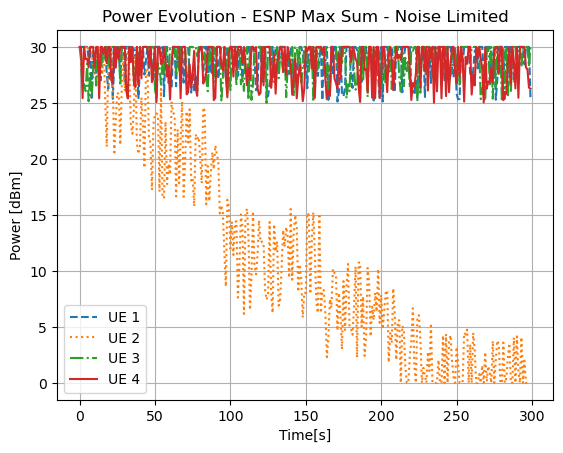

In [145]:
# Plotando a evolução da potência de transmissão MaxSum

plt.figure()
plt.plot(power_evolution_maxsum_noise[0, :], label='UE 1', linestyle='--')
plt.plot(power_evolution_maxsum_noise[1, :], label='UE 2', linestyle=':')
plt.plot(power_evolution_maxsum_noise[2, :], label='UE 3', linestyle='-.')
plt.plot(power_evolution_maxsum_noise[3, :], label='UE 4')
plt.grid()
plt.legend()
plt.xlabel('Time[s]')
plt.ylabel('Power [dBm]')
plt.title('Power Evolution - ESNP Max Sum - Noise Limited')
plt.savefig('Q8_power_evolution_noiselimited_espnsumax.pdf')
plt.show()

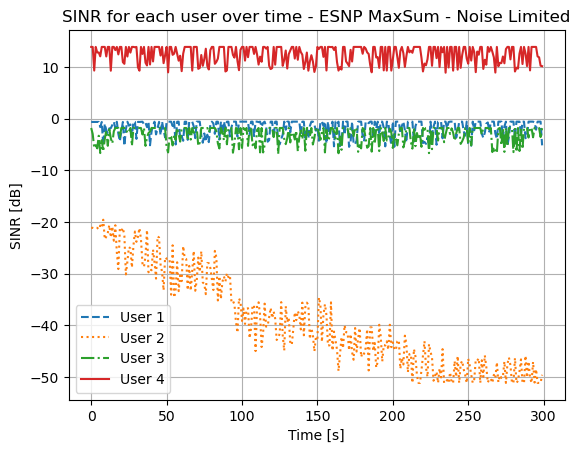

In [146]:
# Plotando a SINR para cada usuário para cada momento utilizando o MaxSum

plt.figure()
plt.plot(sinr_evolution_maxsum_noise[0, :], label='User 1', linestyle='--')
plt.plot(sinr_evolution_maxsum_noise[1, :], label='User 2', linestyle=':')
plt.plot(sinr_evolution_maxsum_noise[2, :], label='User 3', linestyle='-.')
plt.plot(sinr_evolution_maxsum_noise[3, :], label='User 4')
plt.legend()
plt.xlabel('Time [s]')
plt.ylabel('SINR [dB]')
plt.title('SINR for each user over time - ESNP MaxSum - Noise Limited')
plt.grid()
plt.savefig('Q8_sinr_noiselimited_espnsumax.pdf')
plt.show()

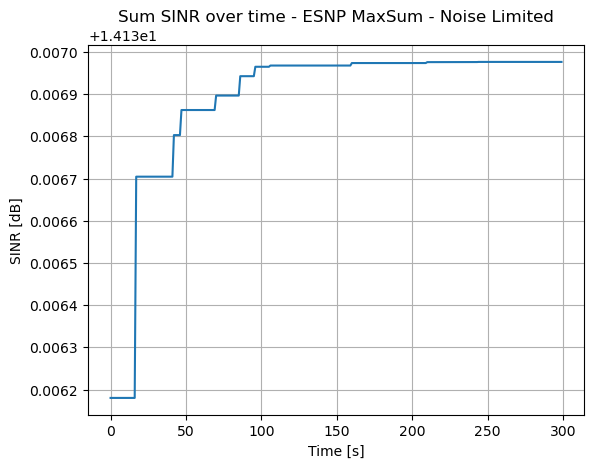

In [147]:
# Plotando a evolução da soma da SINR para cada instante de tempo utilizando o MaxSum
plt.figure()
plt.plot(sum_sinr_evolution_maxsum_noise)
plt.grid()
plt.xlabel('Time [s]')
plt.ylabel('SINR [dB]')
plt.title('Sum SINR over time - ESNP MaxSum - Noise Limited')
plt.savefig('Q8_sum_sinr_noiselimited_espnsumax.pdf')
plt.show()


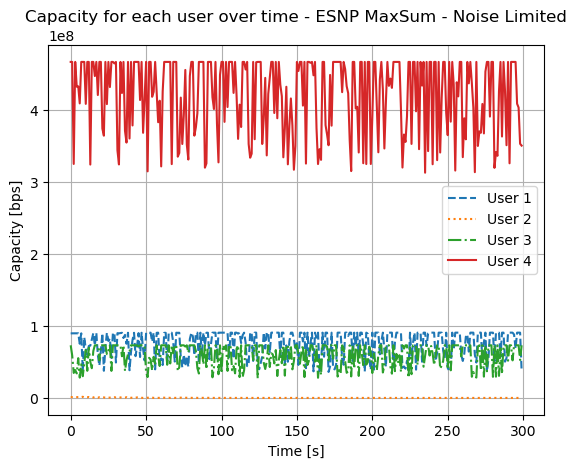

In [148]:
# Plotando a capacidade para cada usuário para cada momento utilizando o MaxSum

plt.figure()
plt.plot(capacity_esnp_maxsum_noise[0, :], label='User 1', linestyle='--')
plt.plot(capacity_esnp_maxsum_noise[1, :], label='User 2', linestyle=':')
plt.plot(capacity_esnp_maxsum_noise[2, :], label='User 3', linestyle='-.')
plt.plot(capacity_esnp_maxsum_noise[3, :], label='User 4')
plt.legend()
plt.xlabel('Time [s]')
plt.ylabel('Capacity [bps]')
plt.title('Capacity for each user over time - ESNP MaxSum - Noise Limited')
plt.grid()
plt.savefig('Q8_capacity_noiselimited_espnsumax.pdf')

In [149]:
# Interference Limited - ESNP Max Sum

best_power_maxsum_interference, power_evolution_maxsum_interference, sinr_evolution_maxsum_interference, sum_sinr_evolution_maxsum_interference, capacity_esnp_maxsum_interference = esnp_maxsum(aps, ues, channels, power_trans_max, power_trans_min, step, time, bandwidth, K_0, area_interferencelimited, x_coord_interference, y_coord_interference, neighb_factor, prob_param, sigma_fastfading, sigma_shadowing)

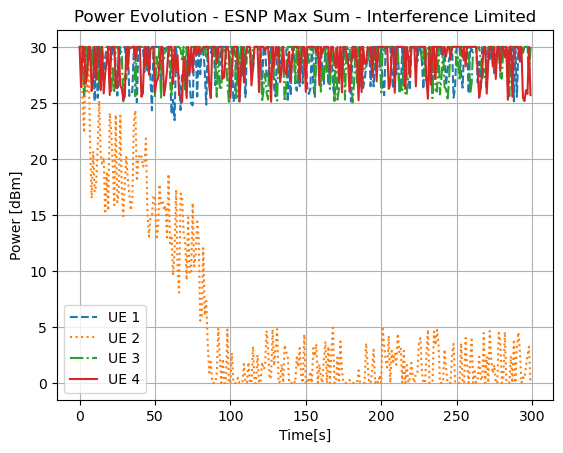

In [150]:
# Plotando a evolução da potência de transmissão MaxSum - Interference Limited

plt.figure()
plt.plot(power_evolution_maxsum_interference[0, :], label='UE 1', linestyle='--')
plt.plot(power_evolution_maxsum_interference[1, :], label='UE 2', linestyle=':')
plt.plot(power_evolution_maxsum_interference[2, :], label='UE 3', linestyle='-.')
plt.plot(power_evolution_maxsum_interference[3, :], label='UE 4')
plt.grid()
plt.legend()
plt.xlabel('Time[s]')
plt.ylabel('Power [dBm]')
plt.title('Power Evolution - ESNP Max Sum - Interference Limited')
plt.savefig('Q8_power_evolution_interferencelimited_espnsumax.pdf')
plt.show()


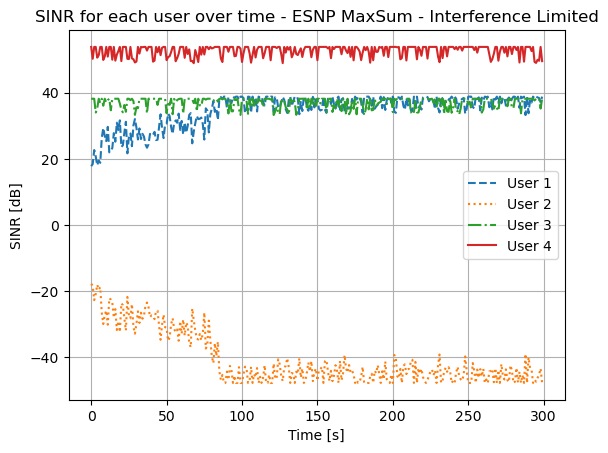

In [151]:
# Plotando a SINR para cada usuário para cada momento utilizando o MaxSum - Interference Limited

plt.figure()
plt.plot(sinr_evolution_maxsum_interference[0, :], label='User 1', linestyle='--')
plt.plot(sinr_evolution_maxsum_interference[1, :], label='User 2', linestyle=':')
plt.plot(sinr_evolution_maxsum_interference[2, :], label='User 3', linestyle='-.')
plt.plot(sinr_evolution_maxsum_interference[3, :], label='User 4')
plt.legend()
plt.xlabel('Time [s]')
plt.ylabel('SINR [dB]')
plt.title('SINR for each user over time - ESNP MaxSum - Interference Limited')
plt.grid()
plt.savefig('Q8_sinr_interferencelimited_espnsumax.pdf')
plt.show()

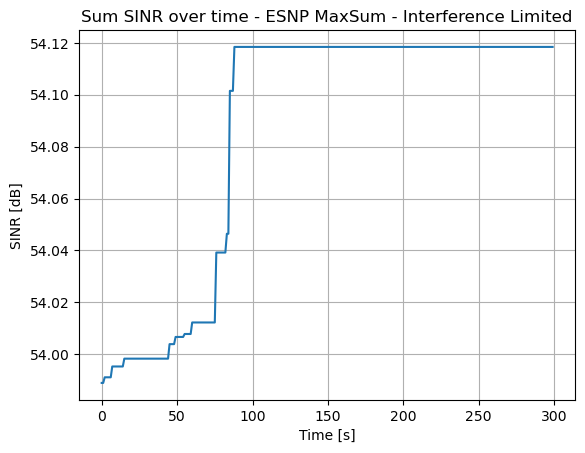

In [152]:
# Plotando a evolução da soma da SINR para cada instante de tempo utilizando o MaxSum - Interference Limited

plt.figure()
plt.plot(sum_sinr_evolution_maxsum_interference)
plt.grid()
plt.xlabel('Time [s]')
plt.ylabel('SINR [dB]')
plt.title('Sum SINR over time - ESNP MaxSum - Interference Limited')
plt.savefig('Q8_sum_sinr_interferencelimited_espnsumax.pdf')
plt.show()

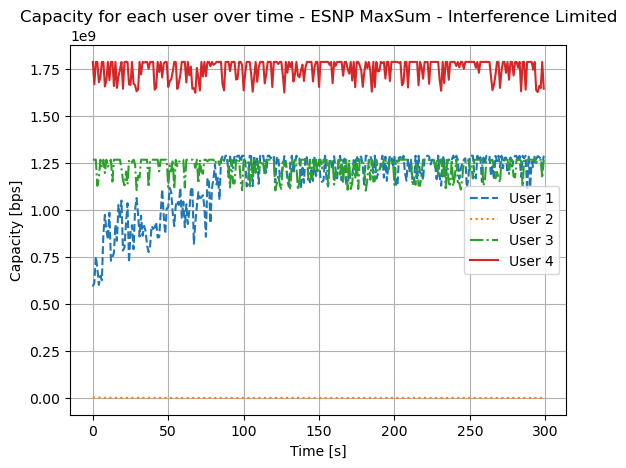

In [153]:
# Plotando a capacidade para cada usuário para cada momento utilizando o MaxSum - Interference Limited

plt.figure()
plt.plot(capacity_esnp_maxsum_interference[0, :], label='User 1', linestyle='--')
plt.plot(capacity_esnp_maxsum_interference[1, :], label='User 2', linestyle=':')
plt.plot(capacity_esnp_maxsum_interference[2, :], label='User 3', linestyle='-.')
plt.plot(capacity_esnp_maxsum_interference[3, :], label='User 4')
plt.legend()
plt.xlabel('Time [s]')
plt.ylabel('Capacity [bps]')
plt.title('Capacity for each user over time - ESNP MaxSum - Interference Limited')
plt.grid()
plt.savefig('Q8_capacity_interferencelimited_espnsumax.pdf')
plt.show()


In [163]:
def esnp_maxminsum(aps, ues, channels, power_trans_max, power_trans_min, step, time, banda, K_0, area, x_coord, y_coord, neighb_factor, epsilon, sigma_fastfading, sigma_shadowing):
    # Inicializa posições dos APs e distâncias
    aps_position = distribuir_APs(aps, area)
    dist = np.zeros((ues, aps))

    # Definindo o shadowing e o fast fading como matrizes fixas
    shadowing = np.array([[5.3434e-2, 2.8731e-1, 1.9691e-2, 7.3013e-1],
                          [3.2318, 1.5770, 2.6449e-1, 5.6379],
                          [6.1470e-3, 1.1424, 2.6826e-1, 4.5709],
                          [1.3485e-1, 4.6690e-1, 7.8250e-1, 1.6742]])
    fastfading = np.array([[1.248699, 3.248041, 0.772754, 0.708962], 
                           [0.498887, 0.104890, 0.647280, 0.940906], 
                           [0.382966, 0.682700, 1.891256, 0.327100], 
                           [0.065737, 0.649500, 1.981107, 1.259538]]).reshape(channels, ues, aps)
    
    fastfading = np.sqrt(fastfading)

    # Salvar a evolução da potência, SINR, capacidade e soma das SINRs
    power_evolution = np.zeros((ues, time))
    sinr_evolution = np.zeros((ues, time))
    capacity_evolution = np.zeros((ues, time))
    sum_sinr_evolution = np.zeros(time)

    # Calculando a distância entre UEs e APs
    for ue_index in range(ues):
        for ap_index in range(aps):
            dist[ue_index][ap_index] = dAPUE(x_coord[ue_index], y_coord[ue_index], aps_position[ap_index])

    # Calculando o path gain
    path_gain = find_pathgain(dist, shadowing, fastfading)
    
    # Setando os valores possíveis de potência de transmissão
    available_power = np.arange(power_trans_min, power_trans_max + step, step)  # em dBm

    # Inicializa vetores de potência e alocação
    transmit_power = power_trans_max * np.ones((ues, 1))  # Potência inicial máxima
    best_power = transmit_power.copy()  # Guarda a melhor configuração de potência
    
    # Valor inicial de função objetivo (soma de SINRs)
    f_sumax = 0

    for time_index in range(time):
        # Calcula a SINR para cada usuário no tempo atual
        sinr_ue = calculate_sinr(banda, K_0, aps, ues, channels, sigma_shadowing, sigma_fastfading, dbm2lin(transmit_power), area, x_coord, y_coord)
        sinr_ue = sinr_ue.reshape((ues, 1))  # Em Linear

        # Salva a evolução de potência e SINR para cada UE
        power_evolution[:, time_index] = transmit_power.flatten()
        sinr_evolution[:, time_index] = lin2db(sinr_ue).flatten()

        # Calcula a capacidade para cada UE em bps usando a largura de banda
        capacity_ue = banda * np.log2(1 + sinr_ue)  # Em bps
        capacity_evolution[:, time_index] = capacity_ue.flatten()

        # Calcula a soma das SINRs em linear
        sum_sinr = np.sum(sinr_ue) * np.min(sinr_ue)

        # Atualiza o valor de melhor função objetivo e potência se o novo valor for melhor
        if sum_sinr > f_sumax:
            f_sumax = sum_sinr
            best_power = transmit_power.copy()

        # Armazena a soma das SINRs em dB para análise
        sum_sinr_evolution[time_index] = lin2db(f_sumax)

        # Escolha aleatória de potência ou ajuste com base no delta
        rand_value = np.random.rand()
        if rand_value < 0:  # Probabilidade baseada em epsilon
            for ue_index in range(ues):
                transmit_power[ue_index] = np.random.choice(available_power)
        else:
            # Ajuste controlado pela vizinhança
            delta = neighb_factor
            perturbation = delta * (np.random.rand(ues, 1) - 0.5)
            transmit_power = best_power + perturbation

        # Aplica restrições de limite de potência
        transmit_power = np.clip(transmit_power, power_trans_min, power_trans_max)

    return best_power, power_evolution, sinr_evolution, sum_sinr_evolution, capacity_evolution


In [164]:
# Noise Limited - ESNP Max Min Sum
best_power_maxminsum_noise, power_evolution_maxminsum_noise, sinr_evolution_maxminsum_noise, maxsumin_sinr_evolution_maxminsum_noise, capacity_esnp_maxminsum_noise = esnp_maxminsum(aps, ues, channels, power_trans_max, power_trans_min, step, time, bandwidth, K_0, area_noiselimited, x_coord_noise, y_coord_noise, neighb_factor, prob_param, sigma_fastfading, sigma_shadowing)

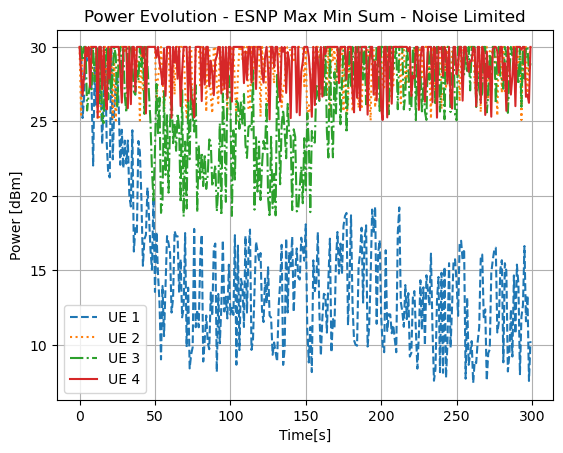

In [165]:
# Plotando a evolução da potência de transmissão MaxMinSum 

plt.figure()
plt.plot(power_evolution_maxminsum_noise[0, :], label='UE 1', linestyle='--')
plt.plot(power_evolution_maxminsum_noise[1, :], label='UE 2', linestyle=':')
plt.plot(power_evolution_maxminsum_noise[2, :], label='UE 3', linestyle='-.')
plt.plot(power_evolution_maxminsum_noise[3, :], label='UE 4')
plt.grid()
plt.legend()
plt.xlabel('Time[s]')
plt.ylabel('Power [dBm]')
plt.title('Power Evolution - ESNP Max Min Sum - Noise Limited')
plt.savefig('Q9_power_evolution_noiselimited_espnsumaxmin.pdf')
plt.show()

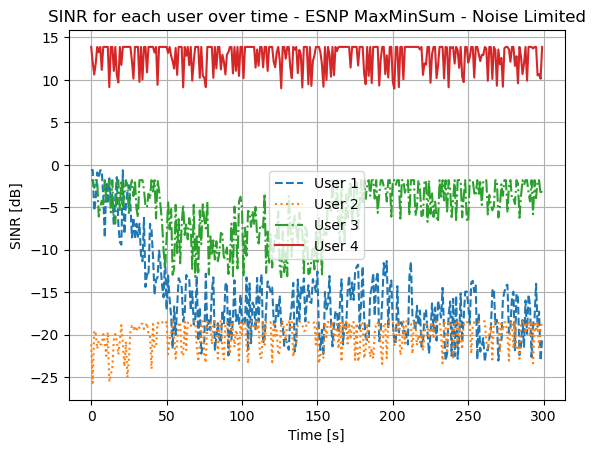

In [166]:
# Plotando a SINR para cada usuário para cada momento utilizando o MaxMinSum

plt.figure()
plt.plot(sinr_evolution_maxminsum_noise[0, :], label='User 1', linestyle='--')
plt.plot(sinr_evolution_maxminsum_noise[1, :], label='User 2', linestyle=':')
plt.plot(sinr_evolution_maxminsum_noise[2, :], label='User 3', linestyle='-.')
plt.plot(sinr_evolution_maxminsum_noise[3, :], label='User 4')
plt.legend()
plt.xlabel('Time [s]')
plt.ylabel('SINR [dB]')
plt.title('SINR for each user over time - ESNP MaxMinSum - Noise Limited')
plt.grid()
plt.savefig('Q9_sinr_noiselimited_espnsumaxmin.pdf')
plt.show()

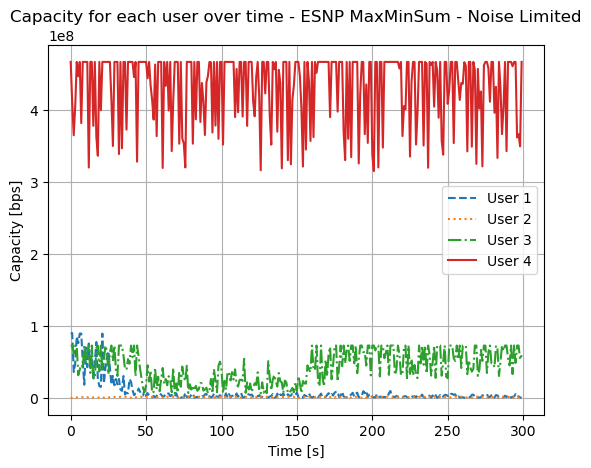

In [167]:
# Plotando a evolução da capacidade para cada instante de tempo utilizando o MaxMinSum

plt.figure()
plt.plot(capacity_esnp_maxminsum_noise[0, :], label='User 1', linestyle='--')
plt.plot(capacity_esnp_maxminsum_noise[1, :], label='User 2', linestyle=':')
plt.plot(capacity_esnp_maxminsum_noise[2, :], label='User 3', linestyle='-.')
plt.plot(capacity_esnp_maxminsum_noise[3, :], label='User 4')
plt.legend()
plt.xlabel('Time [s]')
plt.ylabel('Capacity [bps]')
plt.title('Capacity for each user over time - ESNP MaxMinSum - Noise Limited')
plt.grid()
plt.savefig('Q9_capacity_noiselimited_espnsumaxmin.pdf')
plt.show()

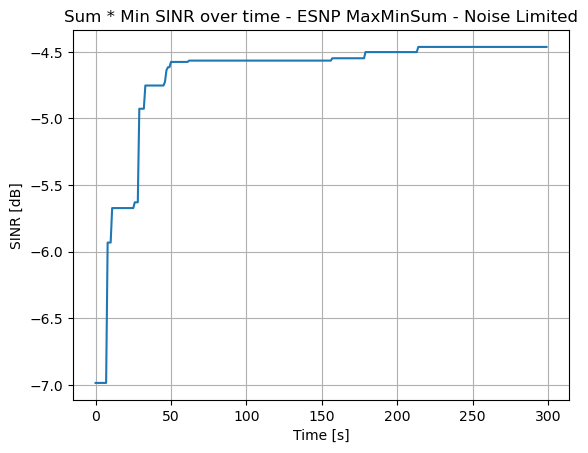

In [172]:
# Plotando a evolução da soma * min da SINR para cada instante de tempo utilizando o MaxMinSum
plt.figure()
plt.plot(maxsumin_sinr_evolution_maxminsum_noise)
plt.grid()
plt.xlabel('Time [s]')
plt.ylabel('SINR [dB]')
plt.title('Sum * Min SINR over time - ESNP MaxMinSum - Noise Limited')
plt.savefig('Q9_maxsumin_sinr_noiselimited_espnsumaxmin.pdf')
plt.show()


In [168]:
# Interference Limited - ESNP Max Min Sum

best_power_maxminsum_interference, power_evolution_maxminsum_interference, sinr_evolution_maxminsum_interference, maxsumin_sinr_evolution_maxminsum_interference, capacity_esnp_maxminsum_interference = esnp_maxminsum(aps, ues, channels, power_trans_max, power_trans_min, step, time, bandwidth, K_0, area_interferencelimited, x_coord_interference, y_coord_interference, neighb_factor, prob_param, sigma_fastfading, sigma_shadowing)

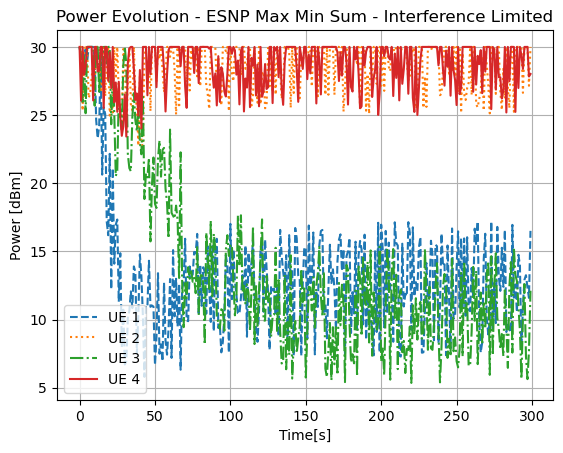

In [169]:
# Plotando a evolução da potência de transmissão MaxMinSum - Interference Limited

plt.figure()
plt.plot(power_evolution_maxminsum_interference[0, :], label='UE 1', linestyle='--')
plt.plot(power_evolution_maxminsum_interference[1, :], label='UE 2', linestyle=':')
plt.plot(power_evolution_maxminsum_interference[2, :], label='UE 3', linestyle='-.')
plt.plot(power_evolution_maxminsum_interference[3, :], label='UE 4')
plt.grid()
plt.legend()
plt.xlabel('Time[s]')
plt.ylabel('Power [dBm]')
plt.title('Power Evolution - ESNP Max Min Sum - Interference Limited')
plt.savefig('Q9_power_evolution_interferencelimited_espnsumaxmin.pdf')
plt.show()

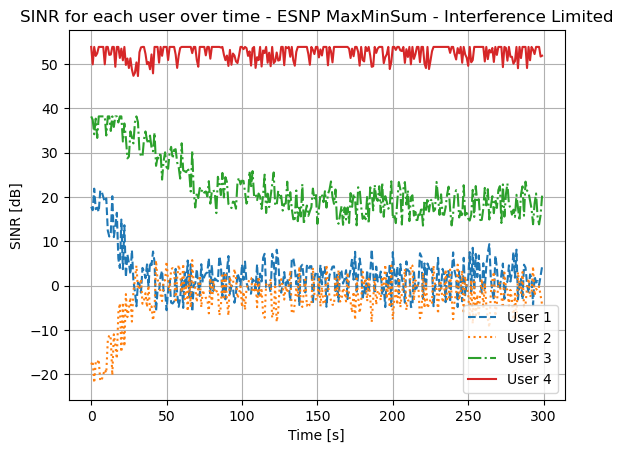

In [170]:
# Plotando a SINR para cada usuário para cada momento utilizando o MaxMinSum - Interference Limited

plt.figure()
plt.plot(sinr_evolution_maxminsum_interference[0, :], label='User 1', linestyle='--')
plt.plot(sinr_evolution_maxminsum_interference[1, :], label='User 2', linestyle=':')
plt.plot(sinr_evolution_maxminsum_interference[2, :], label='User 3', linestyle='-.')
plt.plot(sinr_evolution_maxminsum_interference[3, :], label='User 4')
plt.legend()
plt.xlabel('Time [s]')
plt.ylabel('SINR [dB]')
plt.title('SINR for each user over time - ESNP MaxMinSum - Interference Limited')
plt.grid()
plt.savefig('Q9_sinr_interferencelimited_espnsumaxmin.pdf')
plt.show()

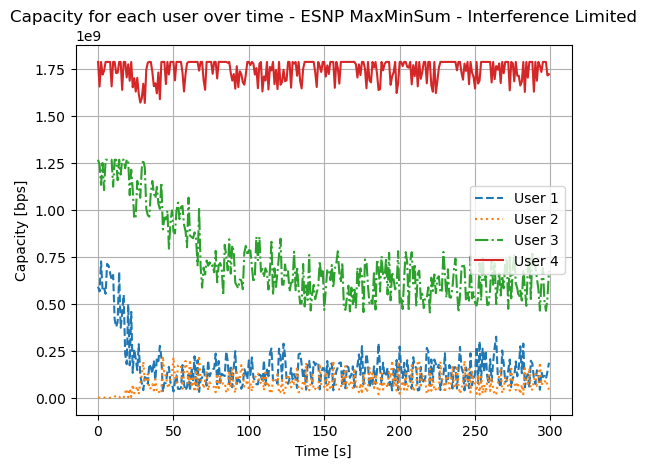

In [171]:
# Plotando a evolução da capacidade para cada instante de tempo utilizando o MaxMinSum - Interference Limited

plt.figure()
plt.plot(capacity_esnp_maxminsum_interference[0, :], label='User 1', linestyle='--')
plt.plot(capacity_esnp_maxminsum_interference[1, :], label='User 2', linestyle=':')
plt.plot(capacity_esnp_maxminsum_interference[2, :], label='User 3', linestyle='-.')
plt.plot(capacity_esnp_maxminsum_interference[3, :], label='User 4')
plt.legend()
plt.xlabel('Time [s]')
plt.ylabel('Capacity [bps]')
plt.title('Capacity for each user over time - ESNP MaxMinSum - Interference Limited')
plt.grid()
plt.savefig('Q9_capacity_interferencelimited_espnsumaxmin.pdf')
plt.show()

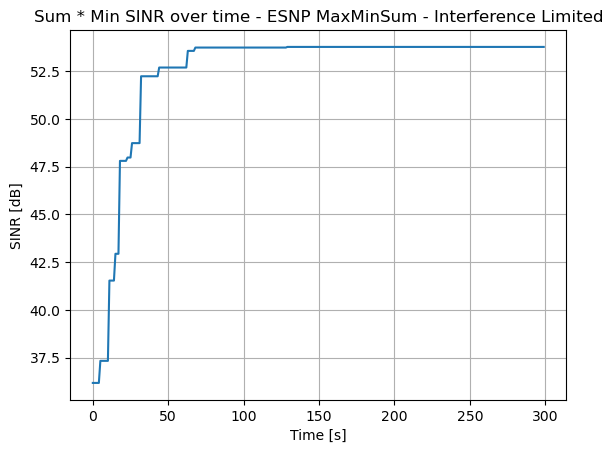

In [173]:
# Plotando a evolução da soma * min da SINR para cada instante de tempo utilizando o MaxMinSum - Interference Limited

plt.figure()
plt.plot(maxsumin_sinr_evolution_maxminsum_interference)
plt.grid()
plt.xlabel('Time [s]')
plt.ylabel('SINR [dB]')
plt.title('Sum * Min SINR over time - ESNP MaxMinSum - Interference Limited')
plt.savefig('Q9_maxsumin_sinr_interferencelimited_espnsumaxmin.pdf')
plt.show()
